In [1]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# from scipy.integrate import odeint
################################################
from autograd.scipy.integrate import odeint
from autograd.builtins import tuple
################################################

# from jax.experimental.ode import odeint
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [2]:
# import jax 
# import jax.numpy as jnp

import autograd.numpy as np   # Thinly-wrapped version of Numpy
from autograd import grad
from autograd import jacobian

In [3]:
from multiprocessing import Pool, Process

In [4]:
# from multiprocessing import multiprocess

In [5]:
#General plotting functions
#Elimates the left and top lines and ticks in a matplotlib plot 
def PlotStyle(Axes,Title):
    
    Axes.spines['top'].set_visible(False)
    Axes.spines['right'].set_visible(False)
    Axes.spines['bottom'].set_visible(True)
    Axes.spines['left'].set_visible(True)
    Axes.xaxis.set_tick_params(labelsize=14)
    Axes.yaxis.set_tick_params(labelsize=14)
    Axes.set_title(Title)

#Lollipop plot based on the python graph gallery implementation 
def LollipopPlot(Fig,Time,Data,Regression):
    
    cTime=Time
    cData=Data
    cRegression=Regression
    
    ax=Fig.gca()

    (markers, stemlines, baseline) = ax.stem(cTime, cData,bottom=-0.4,label='Data',basefmt=" ")
    plt.setp(stemlines, linestyle="-", color="red", linewidth=0.5,alpha=0.5 )
    plt.setp(markers, color="red",alpha=0.75 )

    ax.plot(cTime,cRegression,'b-',label='Regression',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
  
    ax.set_ylabel('Normalized Population',fontsize=16,fontweight='bold')
    ax.set_xlabel('Time',fontsize=16,fontweight='bold')
    ax.legend(loc=0,fontsize=14)
    ax.set_ylim(-0.4,3.4)
    PlotStyle(ax,'')

## Parameter Estimation of Non-Linear ODE system

In [6]:
#Let's consider the Lodka-Volterra model, also known as the predator-prey model. (https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations)

$\frac{\partial R}{\partial t} = R(\alpha - \beta W),  \hspace{1cm} W(0)=W_{0} \\$
$\frac{\partial W}{\partial t} = -W(\gamma - \delta R),\hspace{1cm} R(0)=R_{0}$




In [7]:
#Non linear model
def MakeModel(k_1,k_n1,J_11,phi_pRB,k_p,k_2,a ,k_n2,J_12,phi_E2F1, StateVariables):
    Variables = StateVariables
    Equation1= ((k_1*(Variables[1]/(k_n1+Variables[1]))) * (J_11/(J_11+Variables[0]))) - (phi_pRB*Variables[0])
    Equation2= k_p + ((k_2*((a**2 + Variables[1]**2) / (k_n2**2 + Variables[1]**2))) * (J_12/(J_12+Variables[0]))) \
               - phi_E2F1*Variables[1] 
    
    return np.array([Equation1,Equation2])

#Integration time
GlobalSolverTime=np.linspace(0,800,num=10)

#Parameters of the model 
k_1 = 1
k_n1=0.5
J_11=0.5
phi_pRB=0.005
k_p = 0.05
k_2 = 1.6
a = 0.04
k_n2 = 4
J_12 = 5
phi_E2F1 = 0.1

true_parameter_array = np.array([k_1,k_n1,J_11,phi_pRB,k_p,k_2,a ,k_n2,J_12,phi_E2F1])
# ESTIMATE: k_1, J_11, k_n2, J_12

num_parameters = 10 #Number of parameters in total
est_par_index = [0,2,7,8]
num_unknown_parameters = len(est_par_index)
#True initial conditions 
Int=np.array([1,5])  # [pRB(0), E2F1(0)] 

######################################################
# #Model Solution 
# def ODEModel(StateVariables,t):

#     return MakeModel(k_1,k_n1,J_11,phi_pRB,k_p,k_2,a ,k_n2,J_12,phi_E2F1,StateVariables)

# Solution=odeint(ODEModel,Int,SolverTime)
########################################################

def ODEModel(StateVariables,t,k_1,k_n1,J_11,phi_pRB,k_p,k_2,a,k_n2,J_12,phi_E2F1):

    return MakeModel(k_1,k_n1,J_11,phi_pRB,k_p,k_2,a ,k_n2,J_12,phi_E2F1,StateVariables)

Solution = odeint(ODEModel,Int,GlobalSolverTime,tuple([k_1,k_n1,J_11,phi_pRB,k_p,k_2,a ,k_n2,J_12,phi_E2F1]))

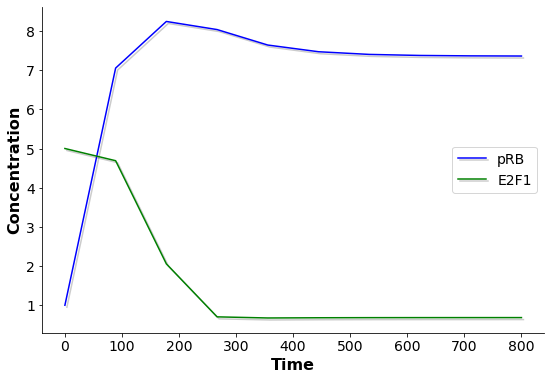

In [8]:
#Visualization
plt.figure(1,figsize=(9,6))

plt.plot(GlobalSolverTime,Solution[:,0],'b-',label='pRB',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(GlobalSolverTime,Solution[:,1],'g-',label='E2F1',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)

ax=plt.gca()
PlotStyle(ax,'')


In [9]:
# concat_time = np.concatenate((SolverTime,SolverTime))

In [10]:
###############################################################################
#                            Data generation  
###############################################################################
def MakeNoisyData(Data,Noise):
    
    return [val+cal for val,cal in zip(Data,Noise)]

GaussianNoise1=[np.random.normal(0,0.001) for val in Solution[:,0]]  
GaussianNoise2=[np.random.normal(0,0.001) for val in Solution[:,1]]  
Signal1=MakeNoisyData(Solution[:,0],GaussianNoise1)
Signal2=MakeNoisyData(Solution[:,1],GaussianNoise2)

In [11]:
Signal1 = np.asarray(Signal1)
Signal2 = np.asarray(Signal2)

In [12]:
concat_noisy_signal = np.concatenate((Signal1,Signal2))

In [13]:
num_concatdata_points = concat_noisy_signal.shape[0]
num_concatdata_points

20

In [14]:
np.asarray(Signal1).shape

(10,)

In [15]:
# ESTIMATE: k_1, J_11, k_n2, J_12
###############################################################################
#                    ODE system model fitting  
###############################################################################
# LATER: Consider the initial parameters as two extra parameters (so 10+2 = 12 parameters in total)
#ModelSolver is the forward solver/integrator
def ModelSolver(t,k_1,k_n1,J_11,phi_pRB,k_p,k_2,a ,k_n2,J_12,phi_E2F1,InitialConditions):
    
    ck_1 =  k_1
    ck_n1 =  k_n1
    cJ_11 = J_11
    cphi_pRB =  phi_pRB
    ck_p = k_p
    ck_2 = k_2
    ca = a
    ck_n2 = k_n2 
    cJ_12 = J_12
    cphi_E2F1 = phi_E2F1
    
    cInit=InitialConditions
    
    def LocalModel(cInit,t):
        
        return MakeModel(ck_1,ck_n1,cJ_11,cphi_pRB,ck_p,ck_2,ca,ck_n2,cJ_12,cphi_E2F1,cInit)
    
    Solution=odeint(LocalModel,cInit,t)
    
    return np.concatenate((Solution[:,0],Solution[:,1]))

def ModelFit(t,k_1,J_11,k_n2,J_12): #change these if the parameters to be estimated change
    #the values of the other parameters are obtained from their global scope 
    t1,t2 =  t #t1 and t2 should be identical
    return ModelSolver(t1,k_1,k_n1,J_11,phi_pRB,k_p,k_2,a ,k_n2,J_12,phi_E2F1,Int)

# p0 = np.random.rand(4)
p0 = np.array([0.45467901, 0.99152412, 0.89004968, 0.48321337])
weights = np.ones(num_concatdata_points) #Initially, all weights are 1
sigma_now = 1/np.sqrt(weights)
ModelParams01=curve_fit(ModelFit,(GlobalSolverTime,GlobalSolverTime),concat_noisy_signal,p0,sigma=sigma_now)

# #Parameters of the model 
# k_1 = 1
# k_n1=0.5
# J_11=0.5
# phi_pRB=0.005
# k_p = 0.05
# k_2 = 1.6
# a = 0.04
# k_n2 = 4
# J_12 = 5
# phi_E2F1 = 0.1


# FitSolution=ModelSolver(SolverTime,ModelParams01[0][0],ModelParams01[0][1],ModelParams01[0][2],ModelParams01[0][3],Int) #fitted solution

/Users/md.shahriarrahimsiddiqui/opt/anaconda3/envs/myvirtualenv/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [16]:
# p0 = array([0.45467901, 0.99152412, 0.89004968, 0.48321337]) doesn't throw warning.

In [17]:
    
ModelParams01

(array([0.9960161 , 0.50219637, 3.99999157, 4.9995012 ]),
 array([[ 6.25893809e-05, -3.38229830e-05,  2.75222757e-06,
          9.84132621e-06],
        [-3.38229830e-05,  1.82801706e-05, -1.46468823e-06,
         -5.26225905e-06],
        [ 2.75222757e-06, -1.46468823e-06,  1.19220066e-06,
          2.86378132e-06],
        [ 9.84132621e-06, -5.26225905e-06,  2.86378132e-06,
          7.18609356e-06]]))

In [18]:
# ESTIMATE: k_1, J_11, k_n2, J_12

In [19]:
ModelParams01[0]

array([0.9960161 , 0.50219637, 3.99999157, 4.9995012 ])

In [20]:
fitSolverTime = np.linspace(0,800,num=300)

In [21]:
#Visualize fit solution
k_1_fit = ModelParams01[0][0]
J_11_fit = ModelParams01[0][1]
k_n2_fit = ModelParams01[0][2]
J_12_fit = ModelParams01[0][3]
Fit = ModelSolver(fitSolverTime,k_1_fit,k_n1,J_11_fit,phi_pRB,k_p,k_2,a ,k_n2_fit,J_12_fit,phi_E2F1,Int)

In [22]:
prb_fit = Fit[:(int(len(Fit)/2))]
e2f1_fit= Fit[int((len(Fit)/2)):]

In [23]:
prb_fit.shape

(300,)

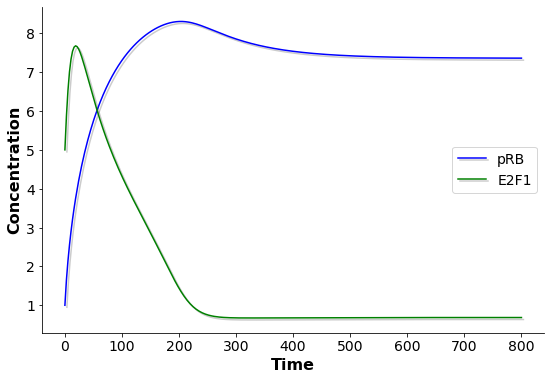

In [24]:
#Visualization
plt.figure(1,figsize=(9,6))
plt.plot(fitSolverTime,prb_fit,'b-',label='pRB',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(fitSolverTime,e2f1_fit,'g-',label='E2F1',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)


ax=plt.gca()
PlotStyle(ax,'')


In [25]:
#ModelSolver is the forward solver/integrator
#True initial conditions 
InitialConditions=np.array([1,5])  # [pRB(0), E2F1(0)] 
#Redefine SolverTime
# SolverTime=np.linspace(0,800,num=10)
def ModelSolver_g(K):
    k_1,k_n1,J_11,phi_pRB,k_p,k_2,a ,k_n2,J_12,phi_E2F1 = K
    t = GlobalSolverTime #defined globally
    ck_1 =  k_1
    ck_n1 =  k_n1
    cJ_11 = J_11
    cphi_pRB =  phi_pRB
    ck_p = k_p
    ck_2 = k_2
    ca = a
    ck_n2 = k_n2 
    cJ_12 = J_12
    cphi_E2F1 = phi_E2F1
    
    cInit=InitialConditions
    
    def LocalModel(cInit,t,ck_1,ck_n1,cJ_11,cphi_pRB,ck_p,ck_2,ca,ck_n2,cJ_12,cphi_E2F1):
        
        return MakeModel(ck_1,ck_n1,cJ_11,cphi_pRB,ck_p,ck_2,ca,ck_n2,cJ_12,cphi_E2F1,cInit)
    
    Solution=odeint(LocalModel,cInit,t,tuple([ck_1,ck_n1,cJ_11,cphi_pRB,ck_p,ck_2,ca,ck_n2,cJ_12,cphi_E2F1]))
    
    return np.concatenate((Solution[:,0],Solution[:,1]))

In [26]:
jacobian_func = jacobian(ModelSolver_g,(0)) #Define the jacobian outputting function

In [27]:
# #Parameters of the model 
# k_1 = 1
# k_n1=0.5
# J_11=0.5
# phi_pRB=0.005
# k_p = 0.05
# k_2 = 1.6
# a = 0.04
# k_n2 = 4
# J_12 = 5
# phi_E2F1 = 0.1

#Let's now take the gradient of ModelSolver with respect to the unknown parameters k_1, J_11, k_n2, J_12

In [28]:
jacobian_output = jacobian_func(np.array([1.0,0.5,0.5,0.005,0.05,1.6,0.04,4.0,5.0,0.1]))

In [29]:
type(jacobian_output)

numpy.ndarray

In [30]:
jacobian_output.shape  #[num_data_points,num_parameters]

(20, 10)

In [ ]:
# ESTIMATE: k_1, J_11, k_n2, J_12
# est_par_index = [0,2,7,8]

In [ ]:
jacobian_estpar = jacobian_output[:,est_par_index]  #this is our J

In [ ]:
jacobian_estpar.shape

In [ ]:
W = np.diag(weights)

In [ ]:
W.shape

In [ ]:
WJ = np.matmul(W,jacobian_estpar) #the "WJ" part in J^T * W * J

In [ ]:
JTJ = np.matmul(jacobian_estpar.T,WJ)  #this is our J_T*W*J which is the Fisher information matrix approximation

In [ ]:
JTJ.shape

In [ ]:
I = JTJ   #Fisher Information Matrix approximation

In [ ]:
np.arange(10)

In [ ]:
temp = np.ones(10)

In [ ]:
temp[est_par_index] = np.array([134,14,151,525])

In [ ]:
temp

In [ ]:
for i in range(num_concatdata_points):
    print(i)

In [ ]:
temp1 = np.array([1,2,3,4])

In [ ]:
1/ np.sqrt(temp1)

In [27]:
#concatenated data is assumed to have Gaussian noise added
def ParameterEstimation(current_weights,S2_concatdata,S2_SolverTime):
    
    # p0 = np.random.rand(4)
    p0 = np.array([0.45467901, 0.99152412, 0.89004968, 0.48321337])
#     weights = np.ones(S2_concatdata) #Initially, all weights are 1
    current_sigma = 1/np.sqrt(current_weights)
#     print(current_sigma.shape)
#     print(S2_concatdata.shape)
    OptimPar_and_covMatrix=curve_fit(ModelFit,(S2_SolverTime,S2_SolverTime),S2_concatdata,p0,sigma=current_sigma)
    
    return OptimPar_and_covMatrix #a tuple, parameters estimated from S2 data points

In [28]:
def CalculateJacobian(ParamEstOutput):
    parameter_array = true_parameter_array #true_parameter_array is defined globally
    parameter_array[est_par_index] = ParamEstOutput[0] #est_par_index is defined globally
    jacobian_output = jacobian_func(parameter_array)
    
    JacobianMatrix = jacobian_output[:,est_par_index]  #this is our J
    
    return JacobianMatrix #numpy array of shape [num_concat_data_points, num_estimated_parameters]

In [41]:
#input index of concatenated data point that we want the weight of
def ComputeWeights(iw):
    # "i" is the index of data points S1
    #JTJ = np.matmul(J.T,J)
    #I = JTJ #approximate total Fisher Information Matrix at optimal parameters. 
    
    #for i in range(num_concatdata_points):
    i = int(iw[0])
    current_weights = iw[1:]
    
#     S2_data_signal1 = np.delete(Signal1,i)
#     S2_data_signal2 = np.delete(Signal2,i)
    S2_SolverTime = np.delete(GlobalSolverTime,i)
    S2_weights = np.delete(current_weights, i)
    
#     S2_concat_data = np.concatenate((S2_data_signal1,S2_data_signal2))
    concat_data = np.concatenate((Signal1,Signal2))
    S2_concat_data = np.delete(concat_data,i)
    
    
#     print(S2_concat_data.shape)
#     print(current_weights.shape)
#     print(S2_weights.shape)
    #returns a tuple
    ParamEstimates_andCovMatrix = ParameterEstimation(S2_weights,S2_concat_data,S2_SolverTime) 
    
    #Now to compute the Jacobian using the parameters estimated from S2
    
    unknown_parameter_estimates = ParamEstimates_andCovMatrix[0]
    temp_parameter_array = true_parameter_array
    temp_parameter_array[est_par_index] = unknown_parameter_estimates
    
    #this computes Jacobian of ALL points with respect to ALL parameters
    jacobian_output = jacobian_func(temp_parameter_array) 
    J = jacobian_output[:,est_par_index]  #this is our J, est_par_index is defined globally
    #Now to form J^T * W * J
    W = np.diag(current_weights)
    ##############################################################################
#     WJ = np.matmul(W,J) #the "WJ" part in J^T * W * J
#     #this is our J_T*W*J which is the Fisher information matrix approximation
#     #This is also I, the total Fisher Information Matrix approximation, using the estimated pars from S2
#     JTWJ = np.matmul(J.T,WJ)   #I
#     ###############################################################################
    
    #First form I_S1
    S1_row_in_jacobian = J[i,:].reshape(1,num_unknown_parameters) #num_unknown_parameters defined globally
    #W should be diagonal, JTWJ_S1 should have shape [num_unknown_parameters,num_unknown_parameters]
    JTWJ_S1 = W[i,i] * np.matmul(S1_row_in_jacobian.T,S1_row_in_jacobian) 
    I_S1 = JTWJ_S1  
    
    #Now form I_S2
    num_time_points = np.arange(len(Signal1))
    S2_indices = (np.setdiff1d(num_time_points,i)).astype(int)
#     print(type(S2_indices))
    #If num of S2 points was 1, you'd need to reshape this. But it probably isn't 1, UNLESS you have two time data points
    S2_rows_in_jacobian = J[S2_indices,:] 
    W_forS2 = np.diag(current_weights[S2_indices])
    WJ_S2 = np.matmul(W_forS2,S2_rows_in_jacobian)
    I_S2 = np.matmul(S2_rows_in_jacobian.T,WJ_S2)
    
    
    I_S1_I_S2 = np.matmul(I_S1,I_S2)
    
    identity_matrix = np.identity(I_S1_I_S2.shape[0])
    I_S1_I_S2_inv = np.linalg.solve(I_S1_I_S2,np.identity_matrix)
    
    uncertainty_of_S1_given_S2 = (1.0/num_unknown_parameters) * np.trace(I_S1_I_S2_inv)
    
    new_S1_weight = uncertainty_of_S1_given_S2
    
    return new_S1_weight

In [39]:
arr[1,:].shape

(21,)

In [42]:
ComputeWeights(arr[1,:])

ValueError: operands could not be broadcast together with shapes (18,) (19,) 

In [32]:
current_weights = np.ones([len(concat_noisy_signal),len(concat_noisy_signal)])

In [33]:
current_weights.shape

(20, 20)

In [34]:
i_array = np.arange(len(concat_noisy_signal)).reshape(len(concat_noisy_signal),1)

In [35]:
i_array.shape

(20, 1)

In [36]:
arr = np.hstack((i_array,current_weights))

In [37]:
arr.shape

(20, 21)

In [38]:
arr = arr[:5,:]

In [69]:
import multiprocess as mp

In [70]:
# ##### START SIMULATION ####
# if __name__ == "__main__":
#     p = Pool()   
#     result1 = p.map(ComputeWeights,arr)
#     p.close()
#     p.join()

# result1 = np.array(result1)
# result1 = result1.squeeze()


with mp.Pool(5) as pool:
    result1 = (pool.map(ComputeWeights, arr))

ValueError: `sigma` has incorrect shape.

# G1/S transition with 6 unknown parameters

In [ ]:
###############################################################################
#                    Standard parameter estimation  
###############################################################################

fig=plt.figure(2,figsize=(9,6))

LollipopPlot(fig,SolverTime,WhiteSignal,FitSolution)

In [ ]:
#The Levenberg-Marquardt algorithm is used by curve_fit to minimize the squared error. Dimensionality of objective
# function is 4 while that of the model is 2, and the default curve_fit initial guesses (all 1's) fail to find an adequate solution

In [ ]:
#Let's do a random search of the initial guess, and make use of the minimize function from scipy.optimize

##############################################################################
#                    Performance measurement
###############################################################################

#Measures the squared error between the data and the fit given an initial parameter guess
def SquaredError(InitialParameterGuess):
    
    try:
        #Some guesses will result in an error or an invalid integration 
        #this ensures that the error is estimated only for valid solutions 
        cModelParams=curve_fit(ModelFit,SolverTime,WhiteSignal,p0=InitialParameterGuess)
        cSolution=ModelSolver(SolverTime,cModelParams[0][0],cModelParams[0][1],cModelParams[0][2],cModelParams[0][3],Int)
    
        error=[(val-sal)**2 for val,sal in zip(cSolution,WhiteSignal)]
        
    except RuntimeError:
        
        #Based on the scale of the data the following list of values will be large enough to be rejected as a solution 
        error=[10,10]
    
    return sum(error)

In [ ]:
'''
Now let's construct a random search algorithm, which will generate a list with "n" different random initial guesses and select the best approximation
'''
###############################################################################
#                    Random Search of initial values  
###############################################################################

#Random selection of the initial guess values 
def RandomSearch(Iterations):
    
    nIt=Iterations 
    GuessContainer=[]
    ErrorContainer=[]
    
    for k in range(nIt):
        
        lGuess=[np.random.uniform(low=0,high=1) for val in range(4)]  #we have 4 parameters to estimate hence range(4), parameters are between 0 to 1
        lerror=SquaredError(lGuess)
        
        GuessContainer.append(lGuess) #Contains the list of random initial values 
        ErrorContainer.append(lerror) #List of the errors 
    
    minError=np.min(ErrorContainer) #Min error value 
    minLocation=[j for j in range(nIt) if ErrorContainer[j]==minError] #Returns the location of the min value in the list
    
    bestGuess=GuessContainer[minLocation[0]] #Best initial value guess 
    
    return ErrorContainer,bestGuess
    
    
errs,bG=RandomSearch(10)     #let's search 10 times randomly

In [ ]:
###############################################################################
#                   Initial values Random Search Fitting 
###############################################################################

ModelParams02=curve_fit(ModelFit,SolverTime,WhiteSignal,p0=bG)
FitSolution2=ModelSolver(SolverTime,ModelParams02[0][0],ModelParams02[0][1],ModelParams02[0][2],ModelParams02[0][3],Int)

In [ ]:
'''
Parameters of the model 
alpha=0.25
beta=0.55
gamma=0.3
delta=0.6
'''
ModelParams02[0][0]

In [ ]:
ModelParams02[0][1]

In [ ]:
ModelParams02[0][2]

In [ ]:
ModelParams02[0][3]

In [ ]:
#We can see that the estimated parameters are close to the input parameters
#Let's see their covariance matrix:
ModelParams02[1]

In [ ]:
sd_array = np.sqrt(np.diag(ModelParams02[1])) #standard deviations of estimated parameters
sd_array

In [ ]:
np.divide(100*sd_array,ModelParams02[0]) #Standard deviations as percentage of estimated parameter values, shows good fit

In [ ]:
###############################################################################
#                              Visualization  
###############################################################################

fig=plt.figure(3,figsize=(9,6))

LollipopPlot(fig,SolverTime,WhiteSignal,FitSolution2)

SUCCESS, now let's try a second approach:

1. Minimize the squared error using an algorithm and get estimates for the parameters.
2. Use the result found in (1) as the initial guess for another least squares optimization (use it in curve_fit)

In [ ]:
'''
A good algorithm for non-differentiable objective functions, or challenging non-linear and noisy optimization problems
is the Nelder-Mead optimization algorithm. It is often used for multidimensional nonlinear function optimization problems, although it can get stuck in local optima.
My reference for this was: https://machinelearningmastery.com/how-to-use-nelder-mead-optimization-in-python/
'''

###############################################################################
#                    Initial values Nelder-Mean Fitting
###############################################################################

#Vector of random initial values 
g0=[np.random.uniform(low=0,high=1) for val in range(4)] 

#Minimization of the squared error by Nelder-Mead 
res = minimize(SquaredError, g0, method='nelder-mead',options={'xtol': 1e-3, 'maxiter':100,'disp': False})



In [ ]:
res.success

In [ ]:
res.message

In [ ]:
'''
Parameters of the model 
alpha=0.25
beta=0.55
gamma=0.3
delta=0.6
'''

res.x    #the 4 parameter estimates

In [ ]:
#Now use the result obtained as the initial guess for curve_fit

ModelParams03=curve_fit(ModelFit,SolverTime,WhiteSignal,p0=res.x)

FitSolution3=ModelSolver(SolverTime,ModelParams03[0][0],ModelParams03[0][1],ModelParams03[0][2],ModelParams03[0][3],Int) #the fitted curve

In [ ]:
ModelParams03[0] #Much better estimates

In [ ]:
ModelParams03[1] #Covariance matrix

In [ ]:
sd_array = np.sqrt(np.diag(ModelParams03[1])) #standard deviations of estimated parameters
sd_array

In [ ]:
np.divide(100*sd_array,ModelParams03[0]) #Standard deviations as percentage of estimated parameter values, shows good fit

In [ ]:
###############################################################################
#                              Visualization 
###############################################################################

fig=plt.figure(4,figsize=(9,6))

LollipopPlot(fig,SolverTime,WhiteSignal,FitSolution3)

In [ ]:
inpData=np.linspace(0,10,20).reshape(-1,2)

In [ ]:
inpData.shape

In [ ]:
inpData.flatten()

In [ ]:
def func(X, a, b, c):
    x,y = X
    result0 = np.log(a) + b*np.log(x[0]) + c*np.log(y[0])
    result1 = np.log(a) + b*np.log(x[1]) + c*np.log(y[1])
    return np.concatenate([result0, result1])

# some artificially noisy data to fit
x0 = np.linspace(0.1,1.1,101)
y0 = np.linspace(1.,2., 101)

x1 = np.linspace(0.1,1.1,101)
y1 = np.linspace(1.,2., 101)

a, b, c = 10., 4., 6.

x = np.array([x0,x1])
y = np.array([y0,y1])

z = func((x,y), a, b, c)
# z[0] = z[0] * 1 + np.random.random(101)/100
# z[1] = z[1] * 1 + np.random.random(101)/100
z = z + np.random.random(2*101)/100
# initial guesses for a,b,c:
p0 = 8., 2., 7.
print(curve_fit(func, (x,y), z, p0))


In [ ]:
Ca0 = 1.0
k1 = k_1 = 3.0

tspan = np.linspace(0, 0.5,10)

def C(K):
    k1, k_1 = K
    def dCdt(Ca, t, k1, k_1):
        return -k1 * Ca + k_1 * (Ca0 - Ca)
    sol = odeint(dCdt, Ca0, tspan, tuple((k1, k_1)))
    return sol

plt.plot(tspan, C([k1, k_1]))
plt.xlim([tspan.min(), tspan.max()])
plt.xlabel('t')
plt.ylabel('C');

In [ ]:
import time
t0 = time.time()
dCdk = jacobian(C, 0)


k_sensitivity = dCdk(np.array([k1, k_1]))

k1_sensitivity = k_sensitivity[:, 0, 0]
k_1_sensitivity = k_sensitivity[:, 0, 1]

plt.plot(tspan, np.abs(k1_sensitivity), label='dC/dk1')
plt.plot(tspan, np.abs(k_1_sensitivity), label='dC/dk_1')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('sensitivity')
print(f'Elapsed time = {time.time() - t0:1.1f} seconds')

In [ ]:
k_sensitivity.shape

In [ ]:
import autograd.numpy as np
from autograd import jacobian

def my_add(K):
    a,b,c,d = K
    return a + b + c + 2*d

a0 = np.array([1.0, 2.0])
b0 = np.array([3.0, 4.0])
c0 = np.array([3.0, 4.0])
d0 = np.array([3.0, 4.0])
my_add_j = jacobian(my_add,argnum=(0))


In [ ]:
jacoutput = my_add_j(np.array([a0, b0,c0,d0]))

In [ ]:
jacoutput[0,:,:].shape

In [ ]:
import autograd.numpy as np
from autograd import jacobian

def my_add(a, b):
    return a + b

a0 = np.array([1.0, 2.0])
b0 = np.array([3.0, 4.0])
my_add_j = jacobian(my_add, argnum=(0, 1))
my_add_j(a0, b0)